# E-tivity 3 - Binary Classification

In [36]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [29]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [30]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [31]:
df['insurance_cost']=df['insurance_cost']>df['insurance_cost'].median()

Let's also examine the histograms of all attribtes.

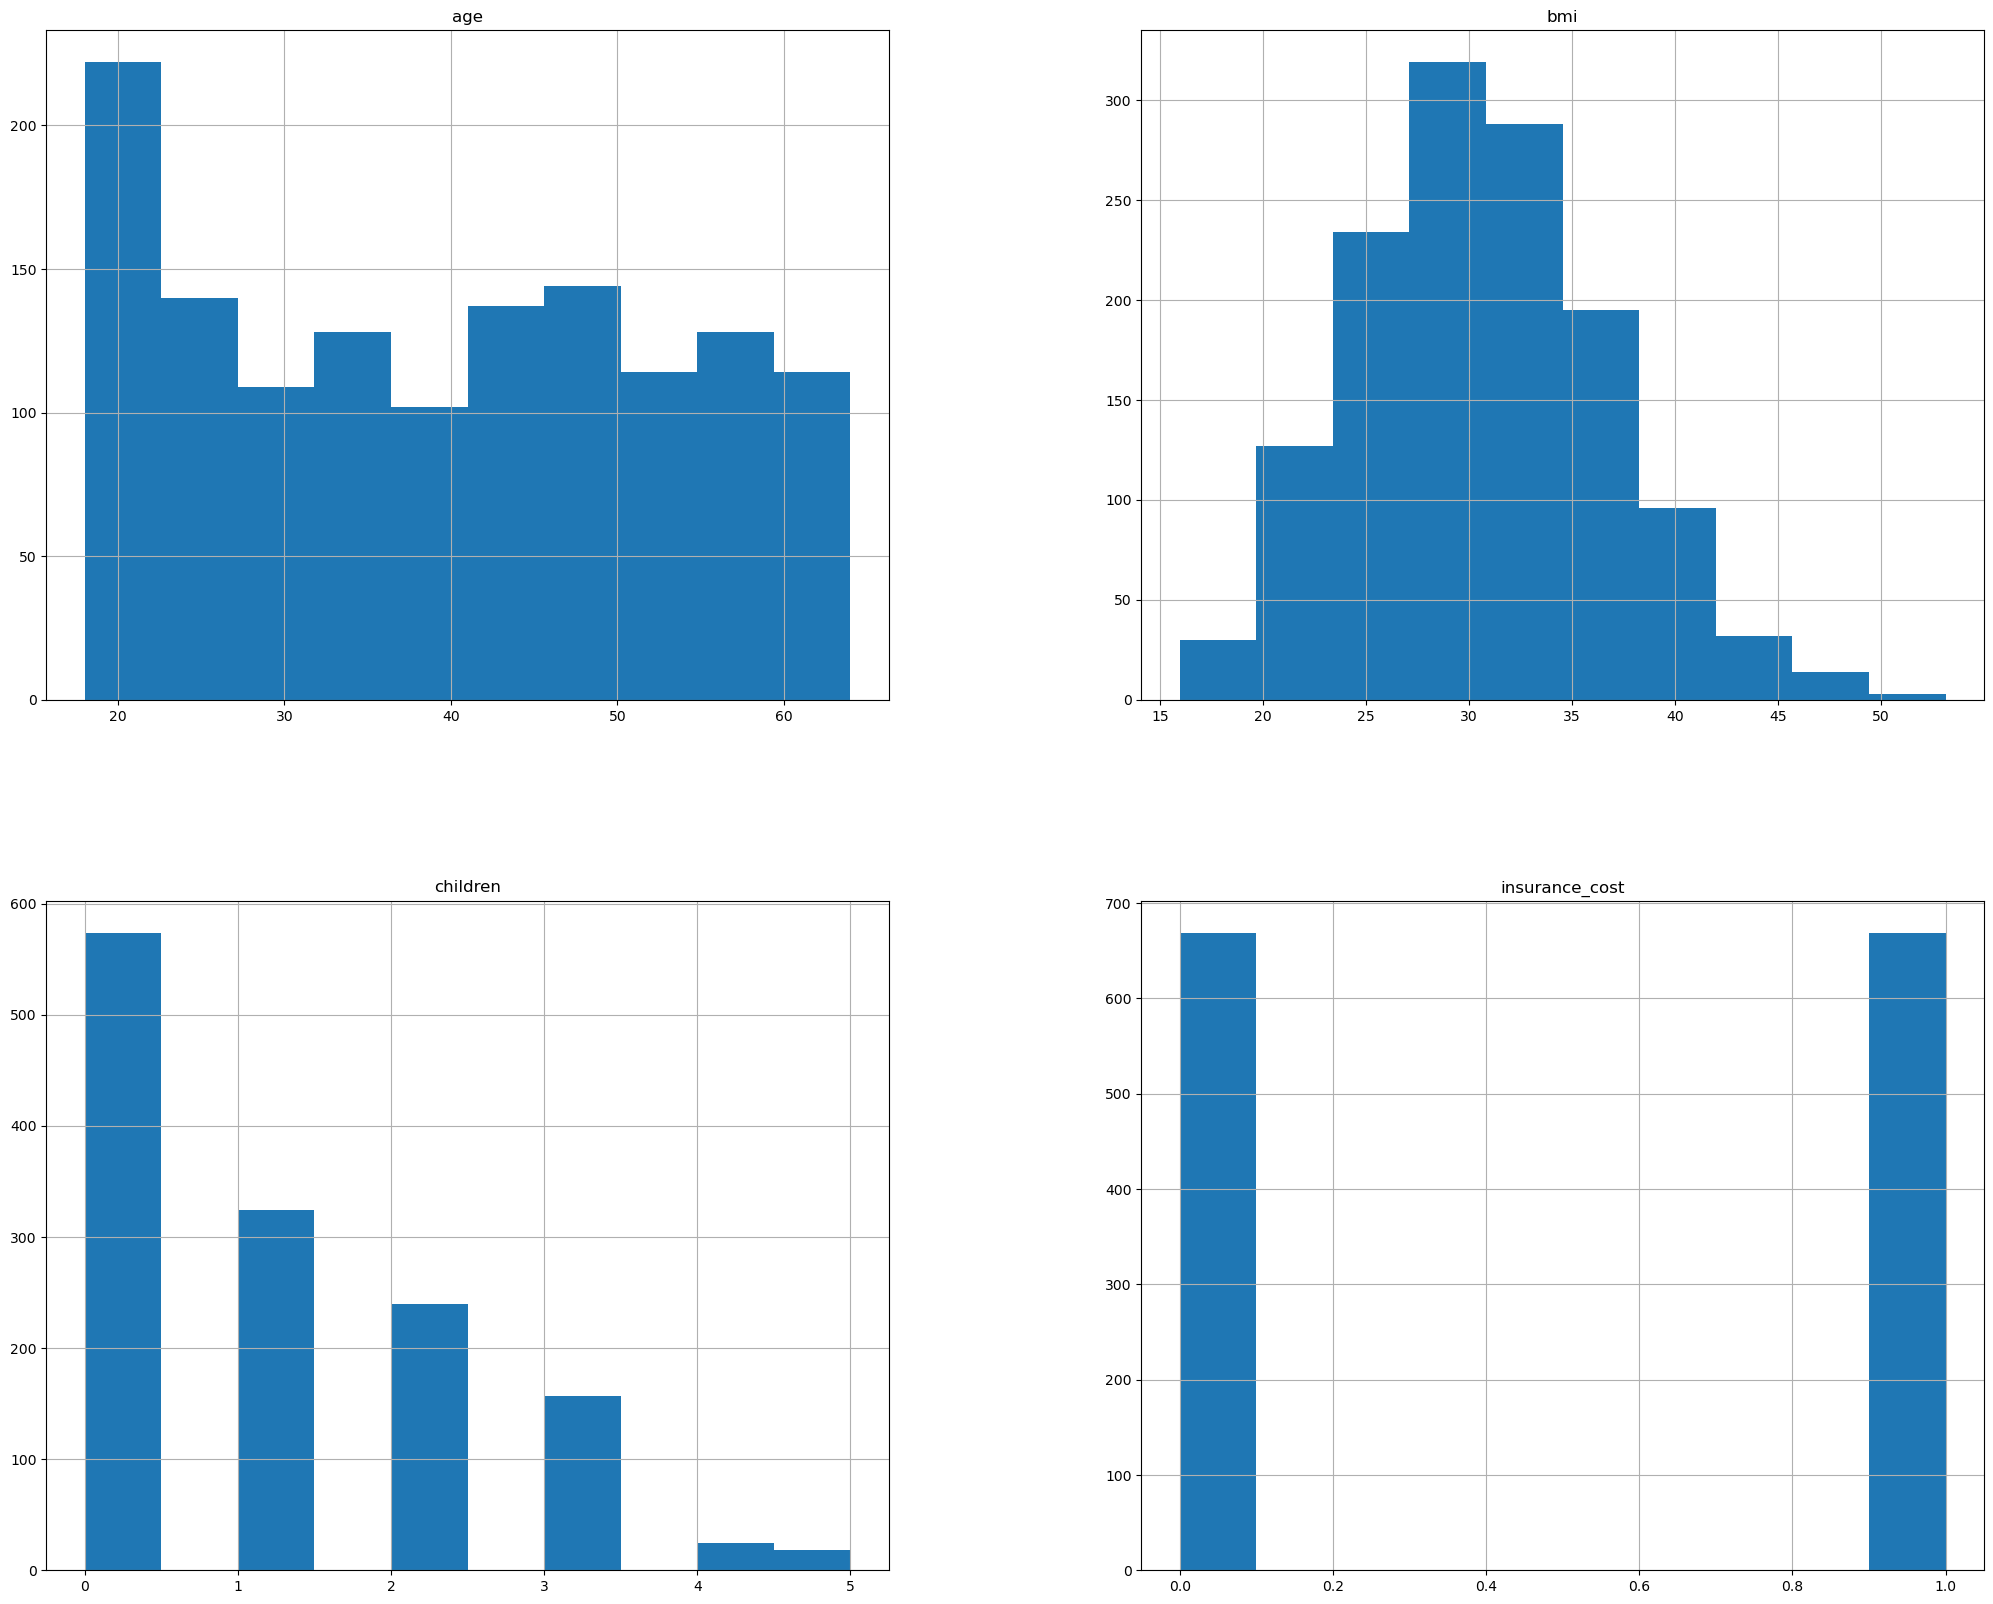

In [35]:
df.hist(bins=10, figsize=(25, 20));

In [39]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

df['insurance_cost'] = df['insurance_cost'].map({True: 1, False: 0})

In [32]:
df['insurance_cost'].value_counts()

0    669
1    669
Name: insurance_cost, dtype: int64

## Data Preparation

Then we can build the preprocessing pipeline by using Pipeline and ColumnTransformer as follows.

In [46]:
num_pipeline = Pipeline(
    steps = [
        ("cbrt_transform", FunctionTransformer(np.cbrt)), 
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps = [
        ("onhot_transform", OneHotEncoder())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("num", num_pipeline, ['age','bmi','children']),    
        ("cat", cat_pipeline, ['gender','smoker','region'])
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

Now we can split the dataset into a training set and a test sets.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

The parameter `stratify=y` ensures that the two classes are represented in the same proportion in both the training and test sets.

## Model Training

### SVM

Next, we train an SVM classification model with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we build another pipeline, the `main pipeline`, which includes the preprocessing pipeline and the SVM classifier. The pipeline takes care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [48]:
# create the pipeline
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('svm', svm.SVC(probability=True))
])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. SVM. Note that we can also add the parameters of the transformers (the ones included in the preprocessing pipeline) to the parameter grid.

In [50]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 5, 10, 100],  
    'svm__gamma': [1, 0.1, 0.05, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=6, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.936:
Best parameters:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


The parameter `refit=True` makes the GridSearchCV train an SVM model on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

### Random Forest

Let's repeat the same experiment but with the Random Forest classifier.

In [51]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

Now, let's train the model by exploring various combinations of values of the parameters of the predictor, i.e. Random Forest.

In [53]:
# prepare a parameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30,40],
    'rf__max_depth': [2, 4, 6, 8,10]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=6, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.944:
Best parameters:  {'rf__max_depth': 10, 'rf__n_estimators': 40}
